Ashly Thampi 21BDA19

In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [26]:
!unzip Villains.zip

Archive:  Villains.zip
replace __MACOSX/._Villains? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [27]:
sdir = "/content/Villains"

In [28]:
IMG_SIZE = (256, 256)
VALID_SPLIT = 0.3
BATCH_SIZE = 32
SEED = 42
PATH = "/content/Villains"

# Get train image with generator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Get validation image with generator
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 100 files belonging to 5 classes.
Using 70 files for training.
Found 100 files belonging to 5 classes.
Using 30 files for validation.


In [29]:
classes = train_ds.class_names

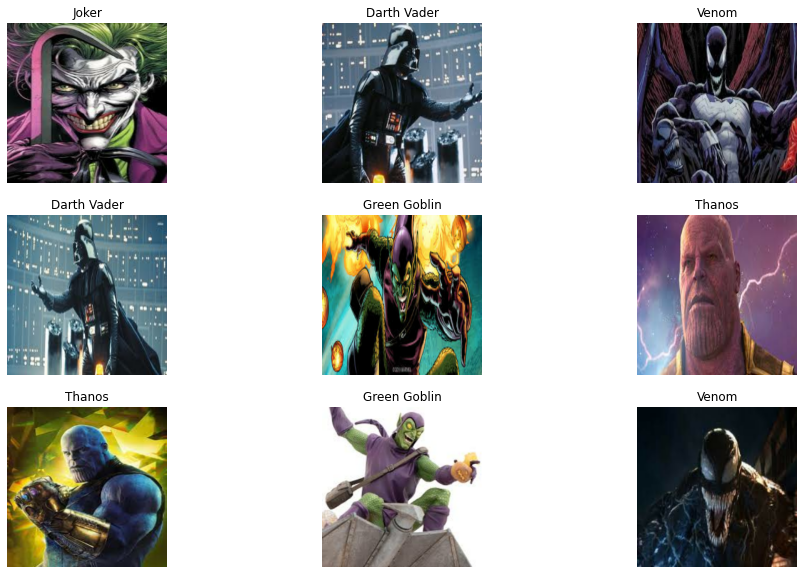

In [ ]:
plt.figure(figsize=(16, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

In [32]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True),y))

In [33]:
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [34]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

print(IMG_SIZE + (3,))
model = make_model(input_shape=IMG_SIZE + (3,), num_classes=len(classes))

(256, 256, 3)


In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['rescaling[0][0]']          

In [36]:
ok = True

if ok:
    # Parameters
    EPOCHS = 10
    CALLBACK = [
        keras.callbacks.ModelCheckpoint(filepath='./model.{epoch:02d}-{val_loss:.2f}.h5'),
        keras.callbacks.EarlyStopping(patience=15)
    ]
    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    
    history = model.fit(
        augmented_train_ds,
        epochs=EPOCHS,
        callbacks=CALLBACK,
        validation_data=val_ds,
    )
    
else:
    model = keras.models.load_model('./indian-food-classification-keras-cnn/save_at_50.h5')

Epoch 1/10
3/3 [==============================] - 50s 13s/step - loss: 1.7781 - categorical_accuracy: 0.2571 - val_loss: 1.6116 - val_categorical_accuracy: 0.1000
Epoch 2/10
3/3 [==============================] - 45s 13s/step - loss: 1.4365 - categorical_accuracy: 0.4000 - val_loss: 1.6125 - val_categorical_accuracy: 0.0667
Epoch 3/10
3/3 [==============================] - 44s 13s/step - loss: 1.0731 - categorical_accuracy: 0.5714 - val_loss: 1.6136 - val_categorical_accuracy: 0.1000
Epoch 4/10
3/3 [==============================] - 46s 13s/step - loss: 1.0686 - categorical_accuracy: 0.6000 - val_loss: 1.6147 - val_categorical_accuracy: 0.1000
Epoch 5/10
3/3 [==============================] - 44s 13s/step - loss: 0.9140 - categorical_accuracy: 0.7286 - val_loss: 1.6152 - val_categorical_accuracy: 0.2333
Epoch 6/10
3/3 [==============================] - 44s 13s/step - loss: 0.8559 - categorical_accuracy: 0.7000 - val_loss: 1.6155 - val_categorical_accuracy: 0.2333
Epoch 7/10
3/3 [======

In [37]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


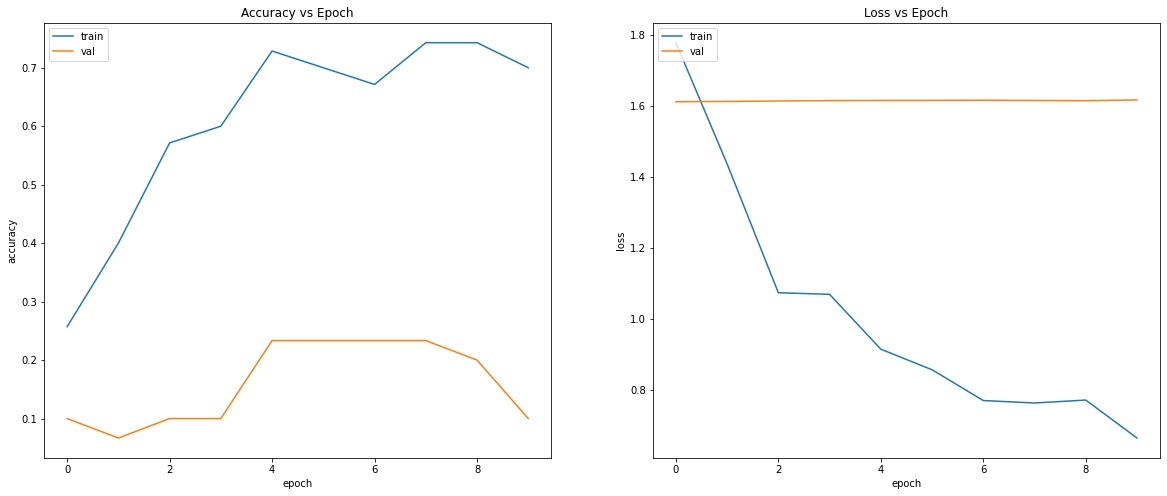

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))


ax[0].plot(history.history['categorical_accuracy'])
ax[0].plot(history.history['val_categorical_accuracy'])
ax[0].set_title('Accuracy vs Epoch')
ax[0].set(xlabel='epoch', ylabel='accuracy')
ax[0].legend(['train', 'val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')


plt.show()